In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import torch
from torch import nn
from torch.utils.data import random_split, Dataset, DataLoader, TensorDataset
from tqdm import trange
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
%load_ext autotime

time: 228 µs (started: 2021-01-26 21:38:58 +07:00)


## Simple

Loss: 0.0004: 100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


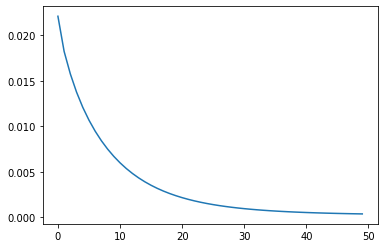

time: 11.8 s (started: 2021-01-26 21:38:58 +07:00)


In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
df = pd.read_csv('./house_data.csv')
X = df[["sq_feet", "num_bedrooms", "num_bathrooms"]]
y = df[["sale_price"]]

X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X.to_numpy())
y_scaled = y_scaler.fit_transform(y.to_numpy())

X = torch.from_numpy(X_scaled).float().to(device)
y = torch.from_numpy(y_scaled).float().to(device)

dataset = TensorDataset(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)
batch_size = 8

train = TensorDataset(X_train, y_train)
train_dl = DataLoader(train, batch_size=batch_size)

model = nn.Linear(3, 1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()
losses = []

with trange(50) as t:
    for i in t:
        for inp, target in train_dl:
            prediction = model(inp)
            optimizer.zero_grad()
            loss = loss_function(prediction, target)
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        t.set_description(f'Loss: {loss:.4f}')

plt.plot(losses)

In [3]:
print("Model training results:")

pred_train = model(X_train)
mse_train = mean_absolute_error(
    y_scaler.inverse_transform(pred_train.detach().numpy()), 
    y_scaler.inverse_transform(y_train.detach().numpy())
)
print(f" - Training Set Error: {mse_train}")

pred_test = model(X_test)
mse_test = mean_absolute_error(
    y_scaler.inverse_transform(pred_test.detach().numpy()), 
    y_scaler.inverse_transform(y_test.detach().numpy())
)
print(f" - Test Set Error: {mse_test}")

Model training results:
 - Training Set Error: 9543.7265625
 - Test Set Error: 9474.736328125
time: 2.02 ms (started: 2021-01-26 21:39:10 +07:00)


## Neural Network

Loss: 0.0013: 100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


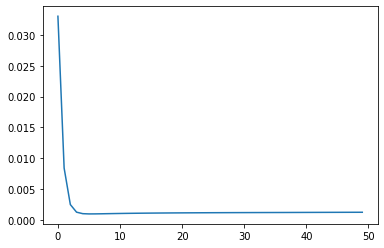

time: 30 s (started: 2021-01-26 21:39:10 +07:00)


In [4]:
H1, H2, H3 = 100, 50, 20
D_in, D_out = 3, 1

# device = "cuda:0"
device = "cpu"
df = pd.read_csv('./house_data.csv')
X = df[["sq_feet", "num_bedrooms", "num_bathrooms"]]
y = df[["sale_price"]]

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X.to_numpy())
y_scaled = y_scaler.fit_transform(y.to_numpy())

X = torch.from_numpy(X_scaled).float().to(device)
y = torch.from_numpy(y_scaled).float().to(device)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)
batch_size = 8

train = TensorDataset(X_train, y_train)

train_dl = DataLoader(train, batch_size=batch_size)

class HouseNet(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, H3),
            nn.ReLU(),
            nn.Linear(H3, D_out)
        )

    def forward(self, x):
        pred = self.net(x)
        return pred


model2 = HouseNet(D_in, H1, H2, H3, D_out).to(device)
loss_fn = nn.MSELoss(reduction='sum')
opt = torch.optim.SGD(model2.parameters(), lr=1e-3)
losses = []

with trange(50) as t:
    for i in t:
        for X, y in train_dl:
            pred = model2(X)
            opt.zero_grad()
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
        losses.append(loss.item())
        t.set_description(f'Loss: {loss:.4f}')

plt.plot(losses)

In [5]:
print("Model training results:")

pred_train = model2(X_train)
mse_train = mean_absolute_error(
    y_scaler.inverse_transform(pred_train.detach().numpy()), 
    y_scaler.inverse_transform(y_train.detach().numpy())
)
print(f" - Training Set Error: {mse_train}")

pred_test = model2(X_test)
mse_test = mean_absolute_error(
    y_scaler.inverse_transform(pred_test.detach().numpy()), 
    y_scaler.inverse_transform(y_test.detach().numpy())
)
print(f" - Test Set Error: {mse_test}")

Model training results:
 - Training Set Error: 9373.4375
 - Test Set Error: 9134.4775390625
time: 8.73 ms (started: 2021-01-26 21:39:40 +07:00)


In [6]:
house_1 = [
    2000, # Size in Square Feet
    3, # Number of Bedrooms
    2, # Number of Bathrooms
]
homes = [
    house_1
]
scaled_home_data = np.array(X_scaler.transform(homes))
home_values = model2(torch.from_numpy(scaled_home_data).float())
unscaled_home_values = y_scaler.inverse_transform(home_values.detach().numpy())
predicted_value = unscaled_home_values[0][0]
# Print the results
print("House details:")
print(f"- {house_1[0]} sq feet")
print(f"- {house_1[1]} bedrooms")
print(f"- {house_1[2]} bathrooms")
print(f"Estimated value: ${predicted_value:,.2f}")

House details:
- 2000 sq feet
- 3 bedrooms
- 2 bathrooms
Estimated value: $383,683.97
time: 1.5 ms (started: 2021-01-26 21:39:40 +07:00)
